In [1]:
import os
import re
import json
import time
import requests
import numpy as np
import pandas as pd

from tqdm import tqdm
import geopandas as gpd

import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

from IPython.display import clear_output
from IPython.core.pylabtools import figsize
%matplotlib inline

In [2]:
sleep_second = 1
estat_path = "./Data/e-stat/"
road_path1 = "./Data/tsukuba_graph/edges/edges.shp"
road_path2 = "./Data/tsukubamirai_graph/edges/edges.shp"
movie_path = "./save"

In [3]:
#path 0m 1h 0d -> 60minutesと返す関数
def get_minutes(path):
    minutes = 0
    for i,t in enumerate(["m", "h", "d"]):
        day_pattern = "[0-9]+%s"%t
        minutes += int(re.search(day_pattern , path).group(0)[:-1]) * [1, 60, 24*60][i]    
    return minutes

#任意の点を含むgeopandasファイルの作成
def get_oneAgent(lat=36.17249687070795, long=140.0077056884763, agent_no=1):
    df = pd.DataFrame(
            {'Agent': ['Agent%s'%agent_no],
             'Latitude': [lat],
             'Longitude': [long]})
    return gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))

#任意の点へのplot
def get_Agents(lat_list, long_list):
    df = pd.DataFrame(
            {'Latitude': lat_list,
             'Longitude':long_list})
    return gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))

#緯度: 35.784944 経度: 139.900149
#緯度: 35.812099 経度: 139.920098
#from_cood = (139.900149, 35.784944)
#to_cood = (139.920098,35.812099)
def get_distance(from_cood, to_cood):
    method="driving" #or foot
    url = "http://router.project-osrm.org/route/v1/%s/%s,%s;%s,%s?overview=false&steps=true&geometries=geojson"%(method, from_cood[0], from_cood[1], to_cood[0], to_cood[1])
    r = requests.get(url)
    time.sleep(sleep_second)    
    data = json.loads(r.text)
    return data["routes"][0]["legs"][0]["distance"] #メートル

#routeを表示, (経度, 緯度)
def get_route(from_cood, to_cood):
    method="driving" #or foot
    url = "http://router.project-osrm.org/route/v1/%s/%s,%s;%s,%s?overview=false&steps=true&geometries=geojson"%(method, from_cood[0], from_cood[1], to_cood[0], to_cood[1])
    r = requests.get(url)
    time.sleep(sleep_second)
    data = json.loads(r.text)
    res_json = data["routes"][0]["legs"][0]["steps"]
    route_cood = [list(from_cood)]
    for i in range(len(res_json)):
        sub_res = res_json[i]["geometry"]["coordinates"]#["steps"] 
        if len(route_cood) == 1:
            for s in sub_res:
                route_cood.append(s)
        else:
            for i,s in enumerate(sub_res):      
                if i > 0:
                    route_cood.append(s)
    route_cood.append(list(to_cood))
    return get_routepath(route_cood)

#routepathをget (経度, 緯度, メートル)
def get_routepath(route_cood):
    dist_list = []
    for i in tqdm(range(len(route_cood)-1)):
        dist_list.append(get_distance(route_cood[i], route_cood[i+1]))
    return np.hstack([np.asarray(route_cood),np.asarray(  dist_list + [0]).reshape(-1,1)])    

#km/h, m/mに変換 
def kmh2mm(k):
    return k/60 * 1000

#from と toの組み合わせを取得
def departure2destination(from_dict, to_dict):
    to_coods = [[p.x,p.y] for p in to_dict["geometry"]] #destinationの緯度経度
    from_coods = [[p.x, p.y] for p in from_dict["geometry"]] #departureの緯度経度
    from_dists = cdist(from_coods, to_coods, metric='euclidean') #距離
    fromto_array = []
    for i,from_dist in enumerate(from_dists):
        fromto_array.append([from_coods[i], to_coods[np.argmin(from_dist)]]) #一番近いfromの緯度経度と,toの緯度経度
    return fromto_array

## Plot examples 

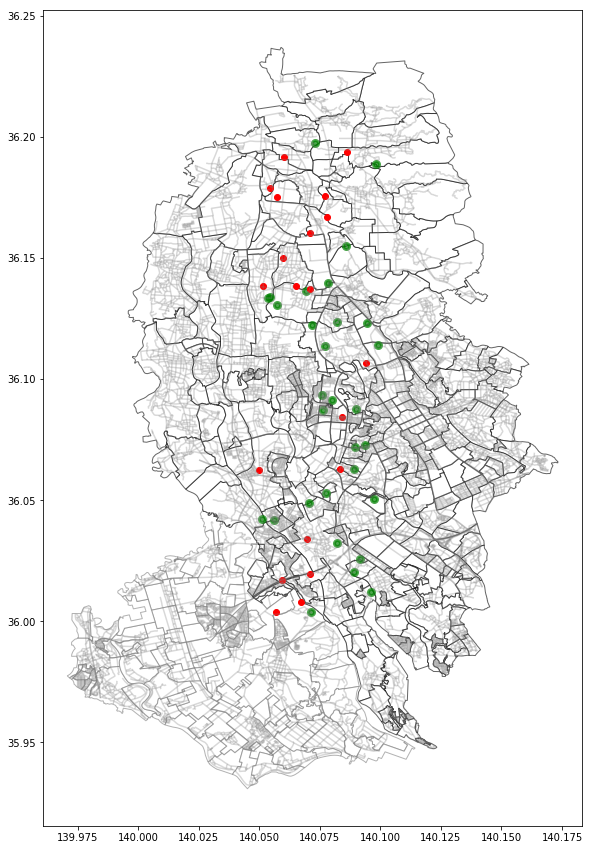

In [4]:
#b
figsize(30,15)

#つくばみらいし
tsukuba_mirai_path =  os.path.join(estat_path,"Tsukubamirai/h27ka08235.shp")
tsukuba_mirai = gpd.read_file(tsukuba_mirai_path).to_crs({'init': 'epsg:4326'}) #.to_crs({'init': 'epsg:4326'})で緯度経度のグラフにできる
base = tsukuba_mirai.plot(alpha=0.6, color='white', edgecolor='gray')

tsukuba_path = os.path.join(estat_path,"Tsukuba/h27ka08220.shp")
tsukuba = gpd.read_file(tsukuba_path).to_crs({'init': 'epsg:4326'})
tsukuba.plot(ax = base, alpha=0.6, color='white', edgecolor='black')#axに加えたいplotを入れれば同時にplotできる

#tsukuba road
tsukuba_road = gpd.read_file(road_path1).to_crs({'init': 'epsg:4326'})
base = tsukuba_road.plot(ax = base, color='gray', alpha=0.3) #axに加えたいplotを入れれば同時にplotできる

tsukubamirai_road = gpd.read_file(road_path2).to_crs({'init': 'epsg:4326'})
base = tsukubamirai_road.plot(ax = base, color='gray', alpha=0.3) #axに加えたいplotを入れれば同時にplotできる

#ランダムに出発地点と目的地を作成
n_from_points = 30
n_to_points = 20
np.random.seed(0)
from_points = np.asarray([np.random.uniform(140.05, 140.1,n_from_points), np.random.uniform(36.0, 36.2,n_from_points)]).T
np.random.seed(1)
to_points = np.asarray([np.random.uniform(140.05, 140.1,n_to_points), np.random.uniform(36.0, 36.2,n_to_points)]).T
from_points = get_Agents(from_points[:,1], from_points[:,0])
to_points = get_Agents(to_points[:,1], to_points[:,0])
from_points.plot(ax = base, linewidth=3, color="green", alpha=0.7)#.to_crs({'init': 'epsg:4326'})
to_points.plot(ax = base, linewidth=1, color="red", alpha=1)#.to_crs({'init': 'epsg:4326'})

## シミュレーション

In [6]:
#各from pointの設定についてをまとめたもの.
reset = False
if not reset:
    #fromから見て最短のtoの組み合わせを取得
    fromto_coods = departure2destination(from_points, to_points)
    fromto_dict = {}
    for p_id in range(from_points.shape[0]):
        fromto_dict[p_id] = {}
        fromto = fromto_coods[p_id]
        fromto_dict[p_id]["route"] = get_route(fromto[0], fromto[1]) #routeの座標と距離のリスト
        fromto_dict[p_id]["cumsum_route_distance"] = np.cumsum(fromto_dict[p_id]["route"][:,2]) #routeごとの距離の累積和
        fromto_dict[p_id]["reach"] = False #到達したか否か
        fromto_dict[p_id]["distance"] = np.sum( fromto_dict[p_id]["route"][:,2])    #to_pointまでのtotal距離
        fromto_dict[p_id]["walked_distance"] = 0 #進んだ距離の和
        fromto_dict[p_id]["walk_speed"] = np.random.uniform(3,5,1) #speed (km/h)

#初期化, 挙動確認にしか使わない        
if reset:
    for p_id in range(from_points.shape[0]):
        fromto_dict[p_id]["cumsum_route_distance"] = np.cumsum(fromto_dict[p_id]["route"][:,2])
        fromto_dict[p_id]["walked_distance"] = 0
        fromto_dict[p_id]["reach"] = False            

100%|██████████| 49/49 [00:20<00:00,  2.63it/s]


In [7]:
#各from pointの設定を元に実際に道路を動かす
##座標の推移を保存するdict
cood_transition = {}
for p_id in range(from_points.shape[0]):
    cood_transition[p_id] = []
    cood_transition[p_id].append(fromto_dict[p_id]["route"][0][:2])

##all_reached(全from poinrtがto pointへ到達)するまでloop
all_reached = False
##合計何回移動したか確認
times = 1
step_minutes = 0.3 #シミュレーション間隔(minutes)
while not all_reached:
    for p_id in range(from_points.shape[0]):
        speed_mm = kmh2mm(fromto_dict[p_id]["walk_speed"])[0]* step_minutes #km/hをメートル/minutesに直し, シミュレーション間隔をかける
        fromto_dict[p_id]["walked_distance"] += speed_mm    #進んだ距離をプラスする
        ##まだ歩いた距離がtotaldistanceより短いならば
        if fromto_dict[p_id]["walked_distance"] < fromto_dict[p_id]["distance"]:
            sum_walked_diff = fromto_dict[p_id]["cumsum_route_distance"] - fromto_dict[p_id]["walked_distance"] #このリストのうち負の値の箇所は通ったことになる
            now_route_idx = np.sum(sum_walked_diff < 0) #
            ##現在通行中の座標間の内、どこまでいけたかを割合で表し、あとで差分をその割合をかけ現在の座標に足し合わせ進んだことにする. 
            ratio = sum_walked_diff[now_route_idx]/fromto_dict[p_id]["route"][now_route_idx][2]
            route_p_id = fromto_dict[p_id]["route"]
            now_cood = route_p_id[now_route_idx][:2]+ ratio *(route_p_id[now_route_idx][:2] - route_p_id[now_route_idx-1][:2])   
            #浸水の話を入れるならば、now_coodが浸水箇所に該当するか否かのif文を加える
        else:
            #もし到達しているなら動かない
            fromto_dict[p_id]["reach"] = True
            now_cood = fromto_dict[p_id]["route"][-1][:2]
        cood_transition[p_id].append(now_cood)
    all_reached = np.prod([fromto_dict[p_id]["reach"] for p_id in range(from_points.shape[0])]) == 1
    times += 1

In [10]:
#上で計算した各from pointの座標を元にplotする
figsize(30,30) 
fillnum = 4 #保存ファイル名の0埋めの数
for step in range(times):
    #area
    if True:
        #b
        base = tsukuba_mirai.plot(alpha=0.6, color='white', edgecolor='gray')
        tsukuba.plot(ax = base, alpha=0.6, color='white', edgecolor='black')#axに加えたいplotを入れれば同時にplotできる   
        #from_points.plot(ax = base, linewidth=3, color="green", alpha=0.5)#.to_crs({'init': 'epsg:4326'})
        to_points.plot(ax = base, linewidth=1, color="red", alpha=0.8)#.to_crs({'init': 'epsg:4326'})
        
    if True:    
        #tsukuba road
        base = tsukuba_road.plot(ax = base, color='gray', alpha=0.3) #axに加えたいplotを入れれば同時にplotできる
        base = tsukubamirai_road.plot(ax = base, color='gray', alpha=0.3) #axに加えたいplotを入れれば同時にplotできる

    if True:
        from_coods = np.asarray([cood_transition[p_id][step] for p_id in range(from_points.shape[0])]).tolist()
        from_coods = get_Agents(np.asarray(from_coods)[:,1], np.asarray(from_coods)[:,0])
        from_coods.plot(ax = base, color='green', markersize=100, alpha=0.8)    
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(os.path.join(movie_path, "%s.png"%str(step).zfill(fillnum)))
    plt.cla()
    plt.clf()
clear_output()

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

In [11]:
#動画作成, ffmpegをcommandで使えるようにしておく必要あり
os.system("ffmpeg -r 30 -i {save_path}/%0{fillnum}d.png -vcodec libx264 -pix_fmt yuv420p -r 60 {save_path}/out.mp4".format(save_path = movie_path, fillnum=fillnum))

0

NameError: name 'j' is not defined